# ABSA Data Exploration

This notebook explores ABSA datasets (Restaurants, Laptops, Tweets) independently, analyzing aspect terms, sentiment distributions, and dataset characteristics. Each dataset is loaded, processed, and visualized separately for clarity and reproducibility, using a consistent set of functions and visualizations.

In [82]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import json
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [83]:
# Utility Functions

def load_absa_data(file_path):
    """Load ABSA data from JSON file and convert to DataFrame"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    processed_data = []
    for item in data:
        text = ' '.join(item['token'])
        if 'aspects' in item and item['aspects']:
            for aspect in item['aspects']:
                processed_data.append({
                    'text': text,
                    'aspect_term': ' '.join(aspect['term']),
                    'polarity': aspect['polarity'],
                    'aspect_start': aspect['from'],
                    'aspect_end': aspect['to'],
                    'text_length': len(text),
                    'word_count': len(item['token']),
                    'pos_tags': item.get('pos', None)
                })
        else:
            processed_data.append({
                'text': text,
                'aspect_term': None,
                'polarity': None,
                'aspect_start': None,
                'aspect_end': None,
                'text_length': len(text),
                'word_count': len(item['token']),
                'pos_tags': item.get('pos', None)
            })
    return pd.DataFrame(processed_data)

def calculate_text_stats(df):
    """Calculate text statistics for the dataset"""
    stats = {
        'total_reviews': df['text'].nunique(),
        'total_aspects': df['aspect_term'].notna().sum(),
        'avg_text_length': df['text_length'].mean(),
        'avg_word_count': df['word_count'].mean(),
        'unique_aspects': df['aspect_term'].nunique(),
        'sentiment_distribution': df['polarity'].value_counts().to_dict()
    }
    return stats

def extract_aspect_categories_dynamic(aspect_terms, top_n=10):
    """
    Assign top N most frequent aspect terms as their own categories, rest as 'Other'.
    """
    terms = pd.Series(aspect_terms).dropna()
    top_terms = terms.value_counts().head(top_n).index.tolist()
    categories = []
    for term in aspect_terms:
        if pd.isna(term):
            categories.append('No Aspect')
        elif term in top_terms:
            categories.append(term)
        else:
            categories.append('Other')
    return categories

def plot_absa_overview(df, dataset_name, sentiment_colors=None, aspect_color=None, word_color=None):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{dataset_name} Dataset Analysis', fontsize=16, fontweight='bold')
    sentiment_counts = df['polarity'].value_counts()
    axes[0,0].pie(sentiment_counts.values, labels=[s.title() if s else 'None' for s in sentiment_counts.index], 
                  autopct='%1.1f%%', startangle=90, colors=sentiment_colors)
    axes[0,0].set_title('Sentiment Distribution')
    aspect_cat_counts = df['aspect_category'].value_counts().head(10)
    axes[0,1].bar(range(len(aspect_cat_counts)), aspect_cat_counts.values, color=aspect_color)
    axes[0,1].set_xticks(range(len(aspect_cat_counts)))
    axes[0,1].set_xticklabels(aspect_cat_counts.index, rotation=45)
    axes[0,1].set_title('Top 10 Aspect Categories')
    axes[0,1].set_ylabel('Count')
    axes[1,0].hist(df['text_length'], bins=50, alpha=0.7, edgecolor='black', color=word_color or 'lightgreen')
    axes[1,0].set_title('Text Length Distribution')
    axes[1,0].set_xlabel('Text Length (characters)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].axvline(df['text_length'].mean(), color='red', linestyle='--', label='Mean')
    axes[1,0].legend()
    axes[1,1].hist(df['word_count'], bins=50, alpha=0.7, edgecolor='black', color='gold')
    axes[1,1].set_title('Word Count Distribution')
    axes[1,1].set_xlabel('Word Count')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].axvline(df['word_count'].mean(), color='red', linestyle='--', label='Mean')
    axes[1,1].legend()
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 8))
    sentiment_aspect = pd.crosstab(df['aspect_category'], df['polarity'], normalize='index') * 100
    sns.heatmap(sentiment_aspect, annot=True, fmt='.1f', cmap='RdYlBu_r', cbar_kws={'label': 'Percentage'})
    plt.title(f'Sentiment Distribution by Aspect Category ({dataset_name} Dataset)', fontsize=14, fontweight='bold')
    plt.xlabel('Sentiment')
    plt.ylabel('Aspect Category')
    plt.tight_layout()
    plt.show()

def plot_top_aspects(df, dataset_name, color='mediumpurple'):
    plt.figure(figsize=(10, 6))
    top_aspects = df.dropna(subset=['aspect_term'])['aspect_term'].value_counts().head(10)
    plt.barh(range(len(top_aspects)), top_aspects.values, color=color)
    plt.yticks(range(len(top_aspects)), top_aspects.index)
    plt.title(f'Top 10 Aspect Terms - {dataset_name} Dataset', fontweight='bold')
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_aspect_wordcloud(df, dataset_name, colormap='Purples'):
    plt.figure(figsize=(10, 5))
    aspect_text = ' '.join(df.dropna(subset=['aspect_term'])['aspect_term'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         colormap=colormap, max_words=100).generate(aspect_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{dataset_name} Aspect Terms Word Cloud', fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## 1. SemEval 2014 Restaurants Dataset

In [84]:
# Load and process Restaurant Dataset
restaurant_train_path = r'c:/Users/tusik/Desktop/bak/Comment-ABSA/data/semeval_datasets/Stanford/Restaurants/train.json'
restaurant_test_path = r'c:/Users/tusik/Desktop/bak/Comment-ABSA/data/semeval_datasets/Stanford/Restaurants/test.json'
restaurant_train = load_absa_data(restaurant_train_path)
restaurant_test = load_absa_data(restaurant_test_path)
restaurant_all = pd.concat([restaurant_train, restaurant_test], ignore_index=True)
restaurant_all['aspect_category'] = extract_aspect_categories_dynamic(restaurant_all['aspect_term'], top_n=10)
restaurant_stats = calculate_text_stats(restaurant_all)

In [85]:
# Restaurant Dataset Overview
print("=== SemEval 2014 Restaurant ABSA Dataset ===")
print(f"Total unique reviews: {restaurant_stats['total_reviews']}")
print(f"Total aspect mentions: {restaurant_stats['total_aspects']}")
print(f"Unique aspect terms: {restaurant_stats['unique_aspects']}")
print(f"Average text length: {restaurant_stats['avg_text_length']:.1f} characters")
print(f"Average word count: {restaurant_stats['avg_word_count']:.1f} words")
print("\nSentiment Distribution:")
for sentiment, count in restaurant_stats['sentiment_distribution'].items():
    if sentiment:
        percentage = (count / restaurant_stats['total_aspects']) * 100
        print(f"  {sentiment.title()}: {count} ({percentage:.1f}%)")

=== SemEval 2014 Restaurant ABSA Dataset ===
Total unique reviews: 2576
Total aspect mentions: 4727
Unique aspect terms: 1703
Average text length: 98.2 characters
Average word count: 19.8 words

Sentiment Distribution:
  Positive: 2891 (61.2%)
  Negative: 1003 (21.2%)
  Neutral: 833 (17.6%)


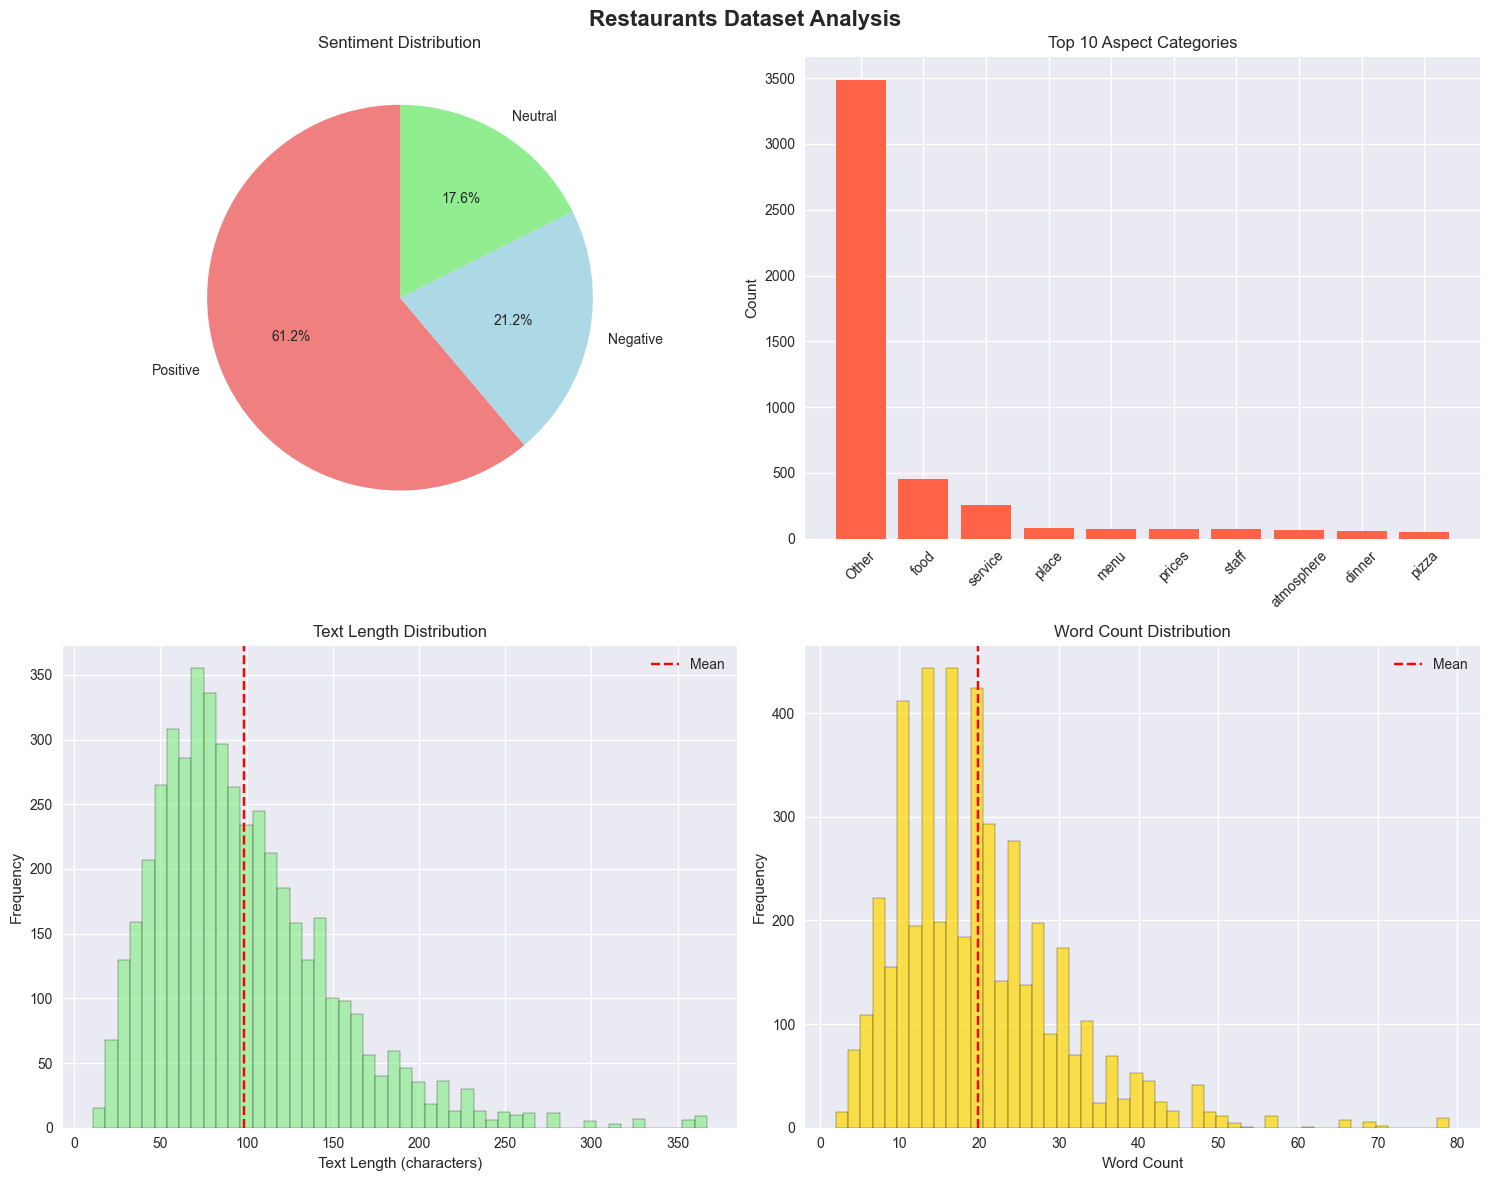

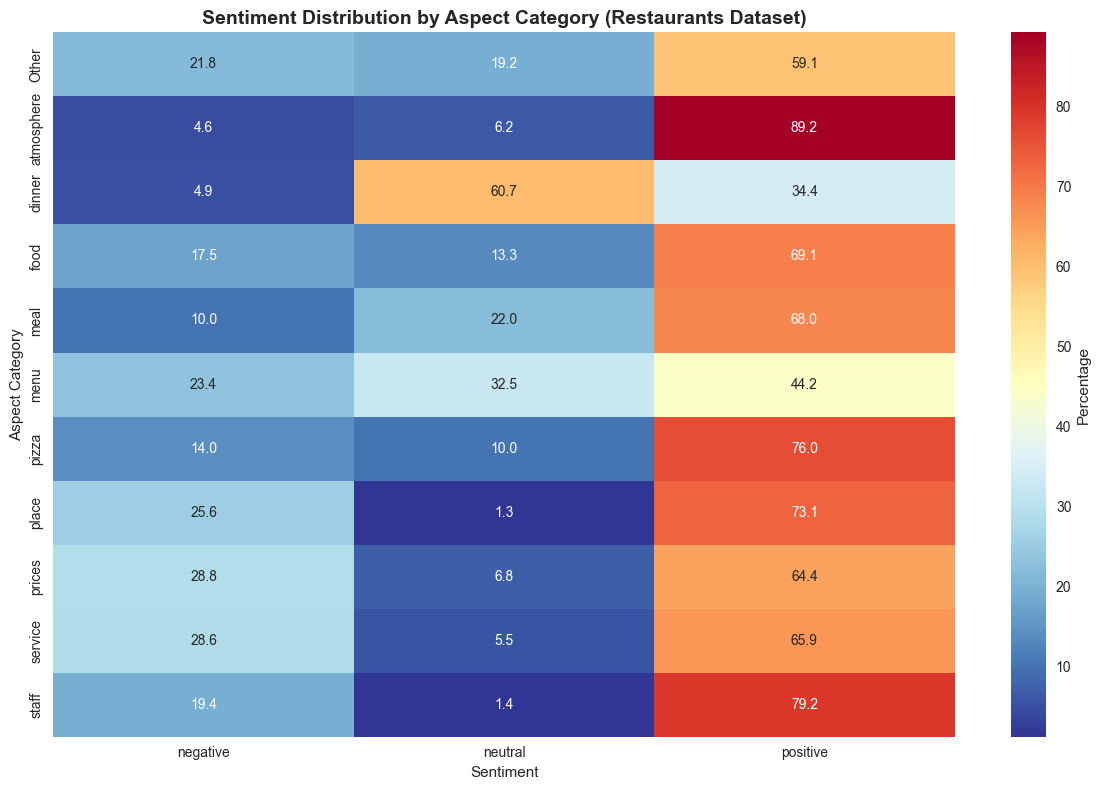

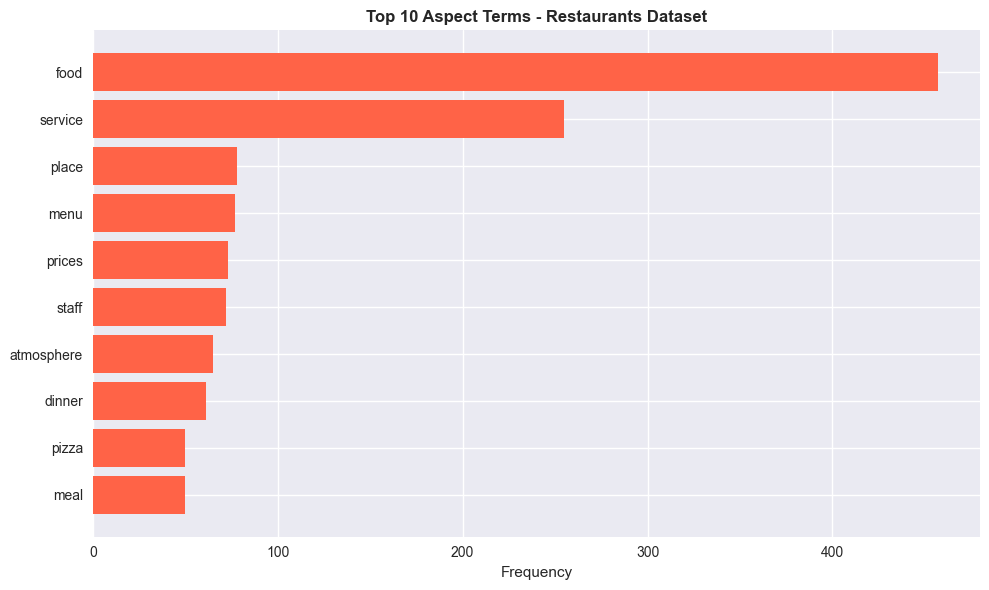

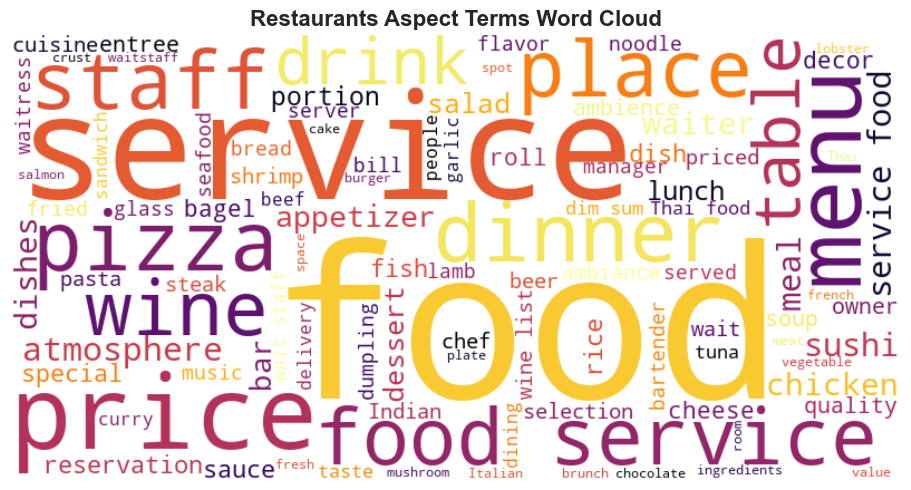

In [86]:
# Restaurant Dataset Visualizations
plot_absa_overview(
    restaurant_all, 
    dataset_name='Restaurants', 
    sentiment_colors=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'],
    aspect_color='tomato',
    word_color='lightgreen'
)
plot_top_aspects(restaurant_all, dataset_name='Restaurants', color='tomato')
plot_aspect_wordcloud(restaurant_all, dataset_name='Restaurants', colormap='inferno')

## 2. SemEval 2014 Laptops Dataset

In [87]:
# Load and process Laptop Dataset
laptop_train_path = r'c:/Users/tusik/Desktop/bak/Comment-ABSA/data/semeval_datasets/Stanford/Laptops/train.json'
laptop_test_path = r'c:/Users/tusik/Desktop/bak/Comment-ABSA/data/semeval_datasets/Stanford/Laptops/test.json'
laptop_train = load_absa_data(laptop_train_path)
laptop_test = load_absa_data(laptop_test_path)
laptop_all = pd.concat([laptop_train, laptop_test], ignore_index=True)
laptop_all['aspect_category'] = extract_aspect_categories_dynamic(laptop_all['aspect_term'], top_n=10)
laptop_stats = calculate_text_stats(laptop_all)

In [88]:
# Laptop Dataset Overview
print("=== SemEval 2014 Laptop ABSA Dataset ===")
print(f"Total unique reviews: {laptop_stats['total_reviews']}")
print(f"Total aspect mentions: {laptop_stats['total_aspects']}")
print(f"Unique aspect terms: {laptop_stats['unique_aspects']}")
print(f"Average text length: {laptop_stats['avg_text_length']:.1f} characters")
print(f"Average word count: {laptop_stats['avg_word_count']:.1f} words")
print("\nSentiment Distribution:")
for sentiment, count in laptop_stats['sentiment_distribution'].items():
    if sentiment:
        percentage = (count / laptop_stats['total_aspects']) * 100
        print(f"  {sentiment.title()}: {count} ({percentage:.1f}%)")

=== SemEval 2014 Laptop ABSA Dataset ===
Total unique reviews: 1853
Total aspect mentions: 2914
Unique aspect terms: 1373
Average text length: 103.0 characters
Average word count: 21.1 words

Sentiment Distribution:
  Positive: 1313 (45.1%)
  Negative: 979 (33.6%)
  Neutral: 622 (21.3%)


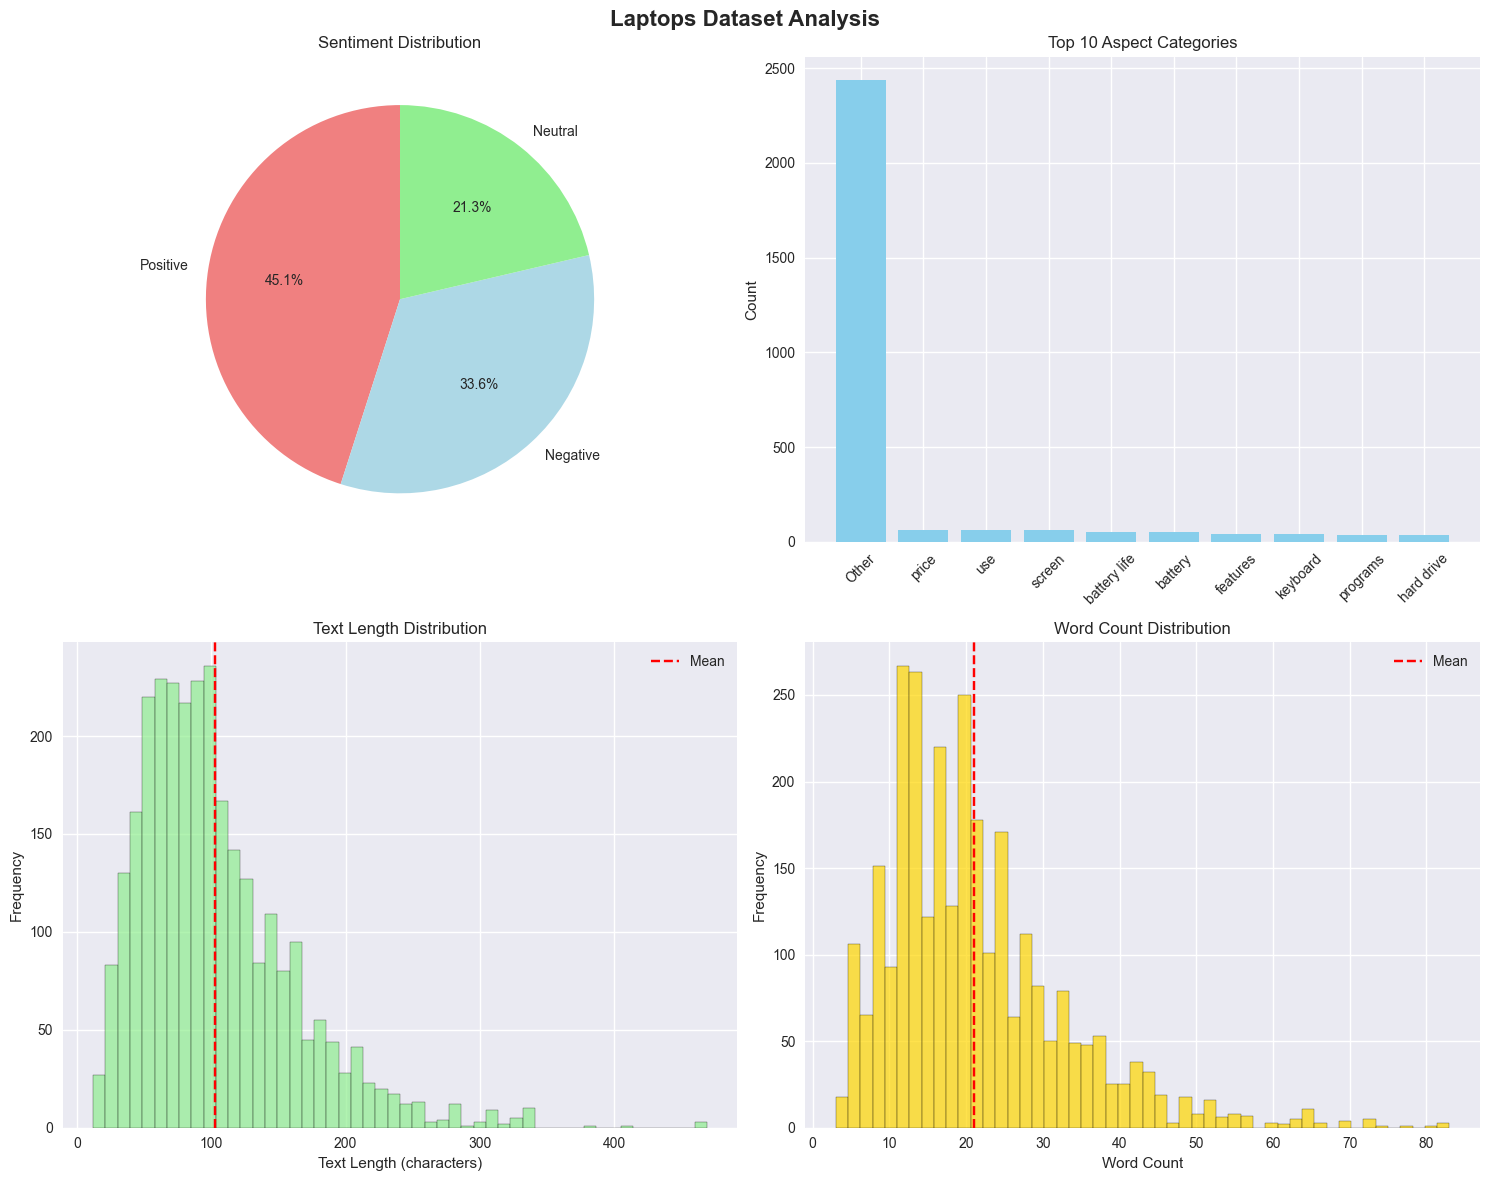

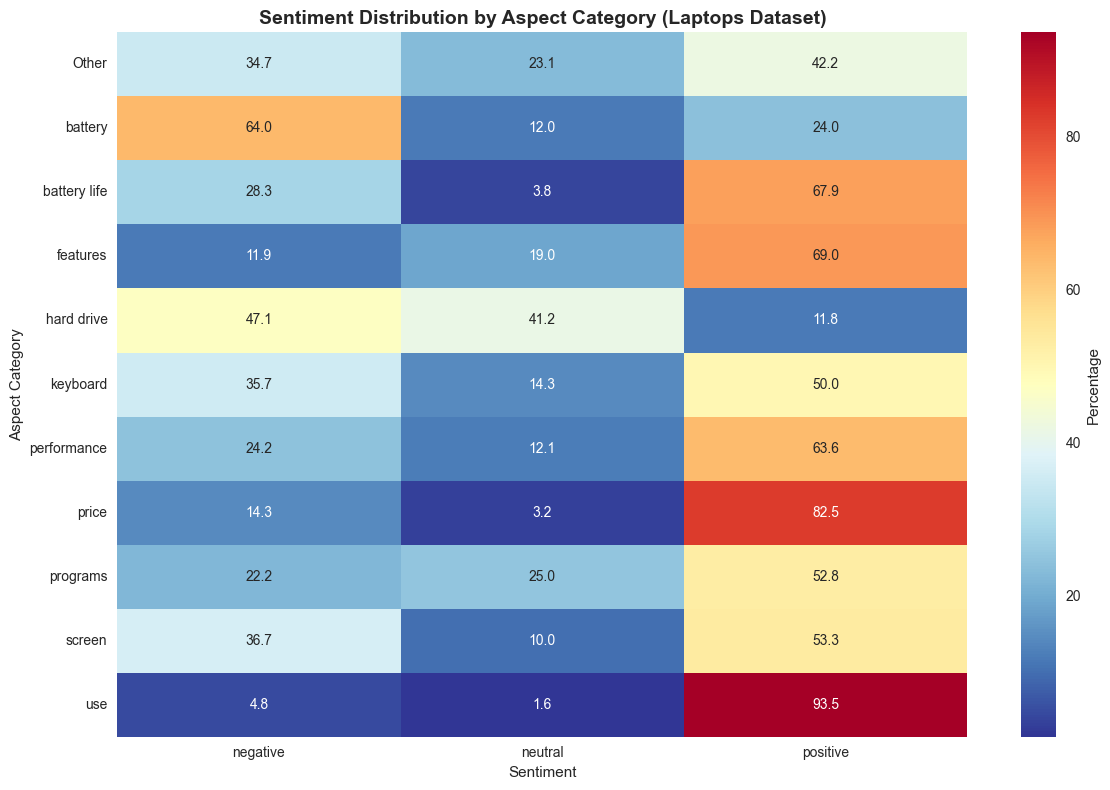

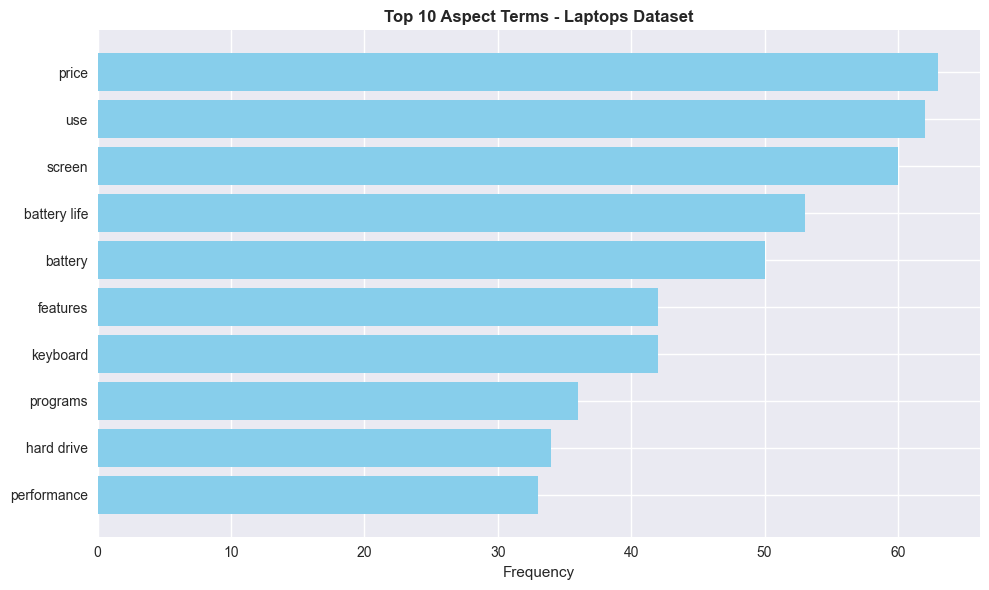

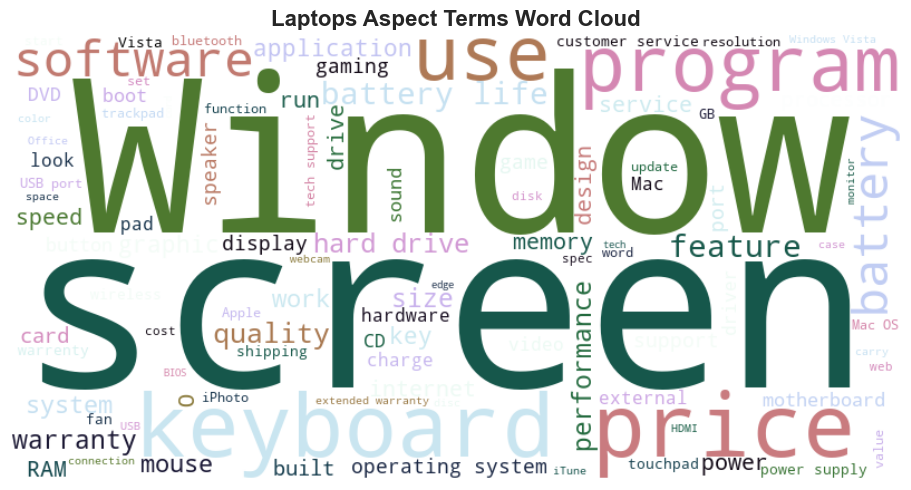

In [89]:
# Laptop Dataset Visualizations
plot_absa_overview(
    laptop_all, 
    dataset_name='Laptops', 
    sentiment_colors=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'],
    aspect_color='skyblue',
    word_color='lightgreen'
)
plot_top_aspects(laptop_all, dataset_name='Laptops', color='skyblue')
plot_aspect_wordcloud(laptop_all, dataset_name='Laptops', colormap='cubehelix')

## 3. SemEval 2014 Tweets Dataset

In [90]:
# Load and process Tweets Dataset
tweets_train_path = r'c:/Users/tusik/Desktop/bak/Comment-ABSA/data/semeval_datasets/Stanford/Tweets/train.json'
tweets_test_path = r'c:/Users/tusik/Desktop/bak/Comment-ABSA/data/semeval_datasets/Stanford/Tweets/test.json'
tweets_train = load_absa_data(tweets_train_path)
tweets_test = load_absa_data(tweets_test_path)
tweets_all = pd.concat([tweets_train, tweets_test], ignore_index=True)
tweets_all['aspect_category'] = extract_aspect_categories_dynamic(tweets_all['aspect_term'], top_n=10)
tweets_stats = calculate_text_stats(tweets_all)

In [91]:
# Tweets Dataset Overview
print("=== SemEval 2014 Tweets ABSA Dataset ===")
print(f"Total unique tweets: {tweets_stats['total_reviews']}")
print(f"Total aspect mentions: {tweets_stats['total_aspects']}")
print(f"Unique aspect terms: {tweets_stats['unique_aspects']}")
print(f"Average text length: {tweets_stats['avg_text_length']:.1f} characters")
print(f"Average word count: {tweets_stats['avg_word_count']:.1f} words")
print("\nSentiment Distribution:")
for sentiment, count in tweets_stats['sentiment_distribution'].items():
    if sentiment:
        percentage = (count / tweets_stats['total_aspects']) * 100
        print(f"  {sentiment.title()}: {count} ({percentage:.1f}%)")

=== SemEval 2014 Tweets ABSA Dataset ===
Total unique tweets: 6720
Total aspect mentions: 6728
Unique aspect terms: 545
Average text length: 99.6 characters
Average word count: 21.1 words

Sentiment Distribution:
  Neutral: 3352 (49.8%)
  Negative: 1697 (25.2%)
  Positive: 1679 (25.0%)


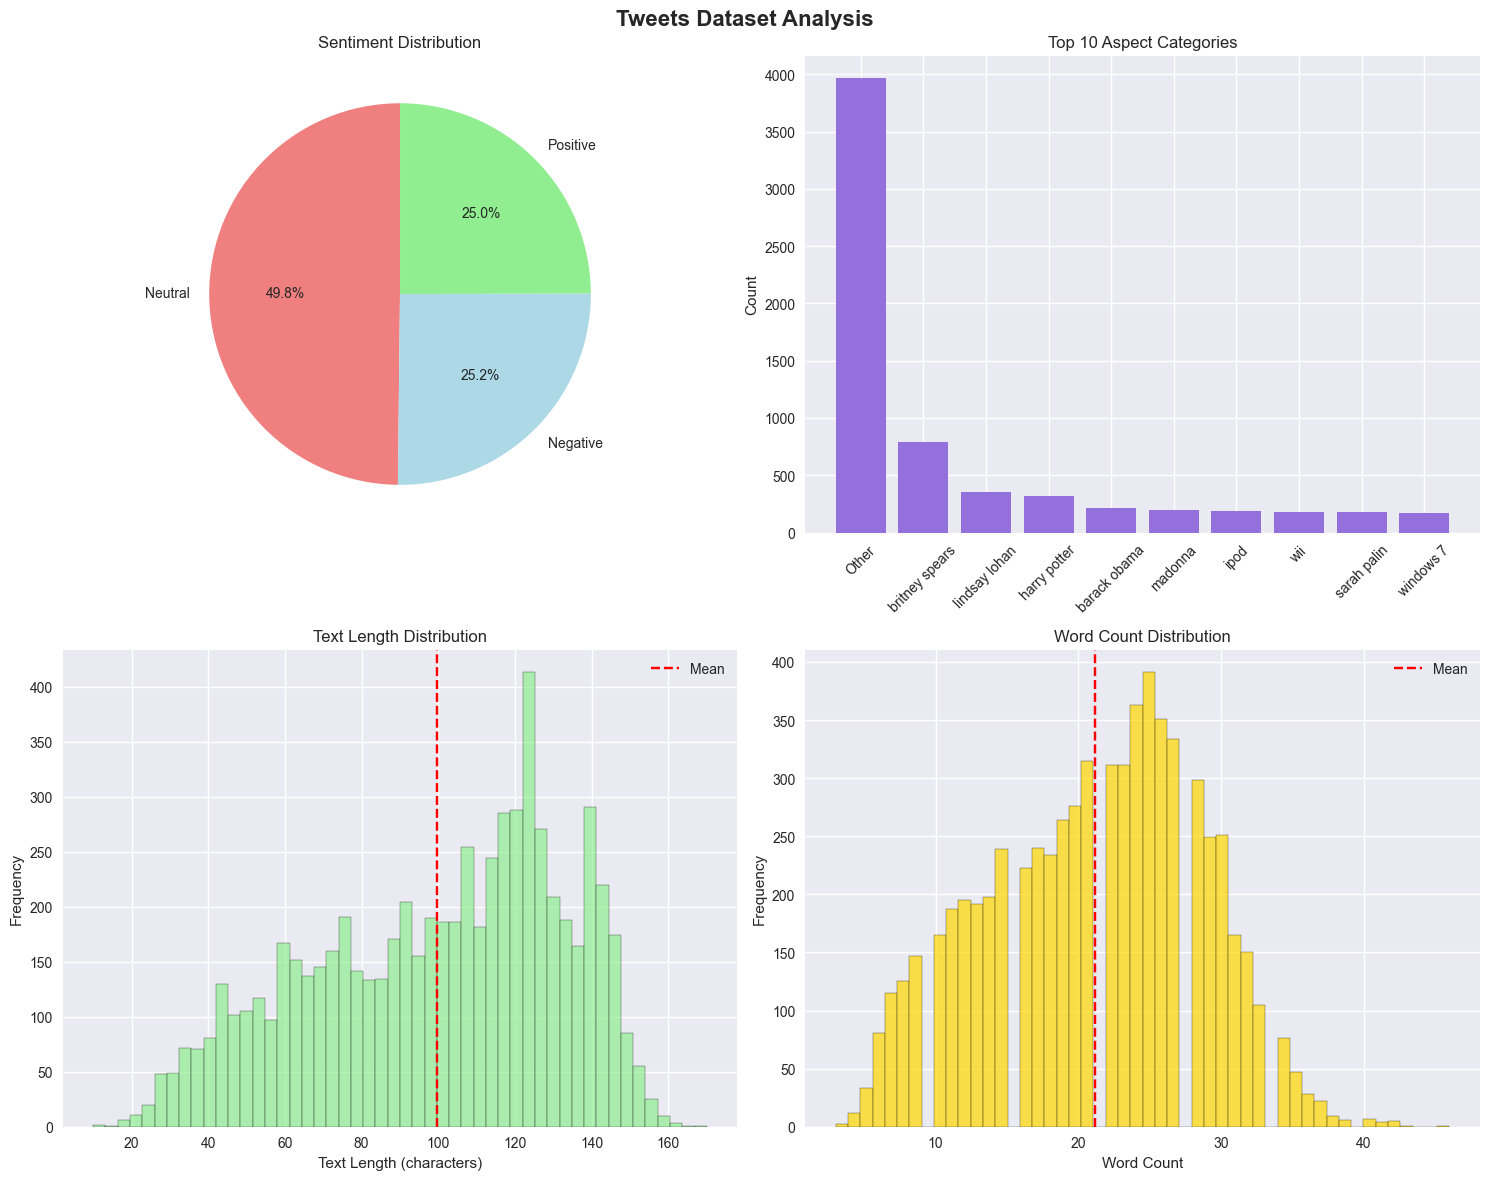

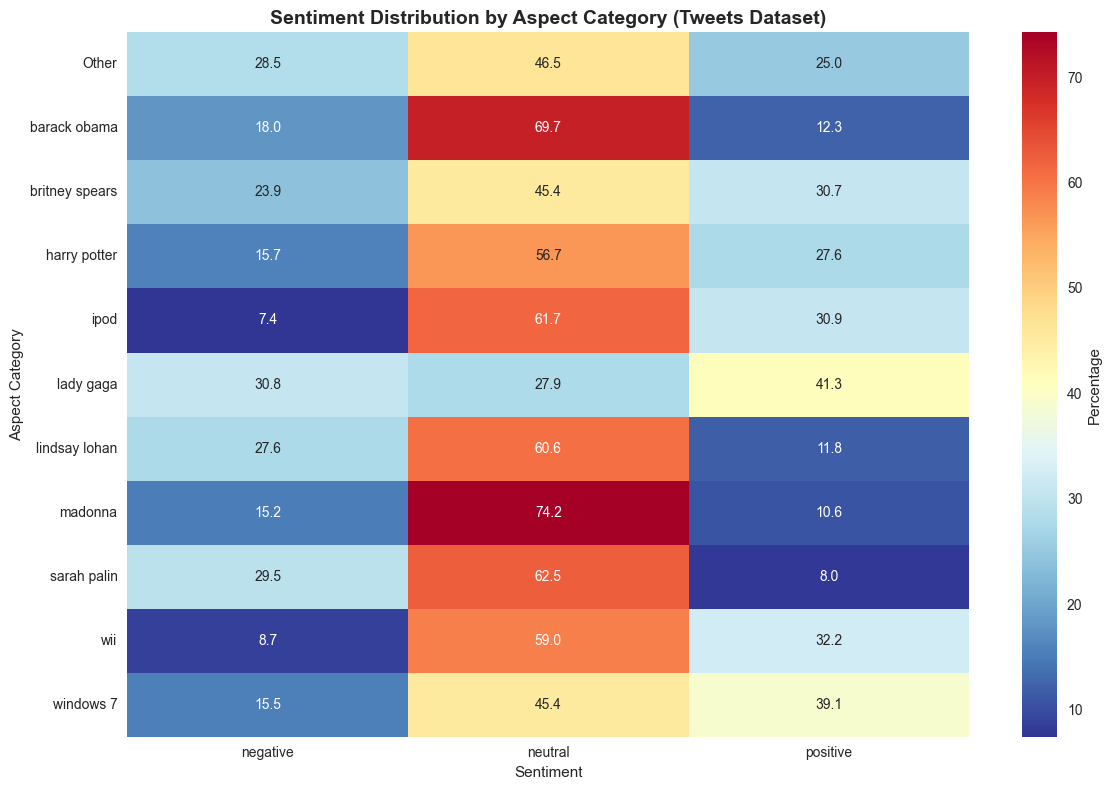

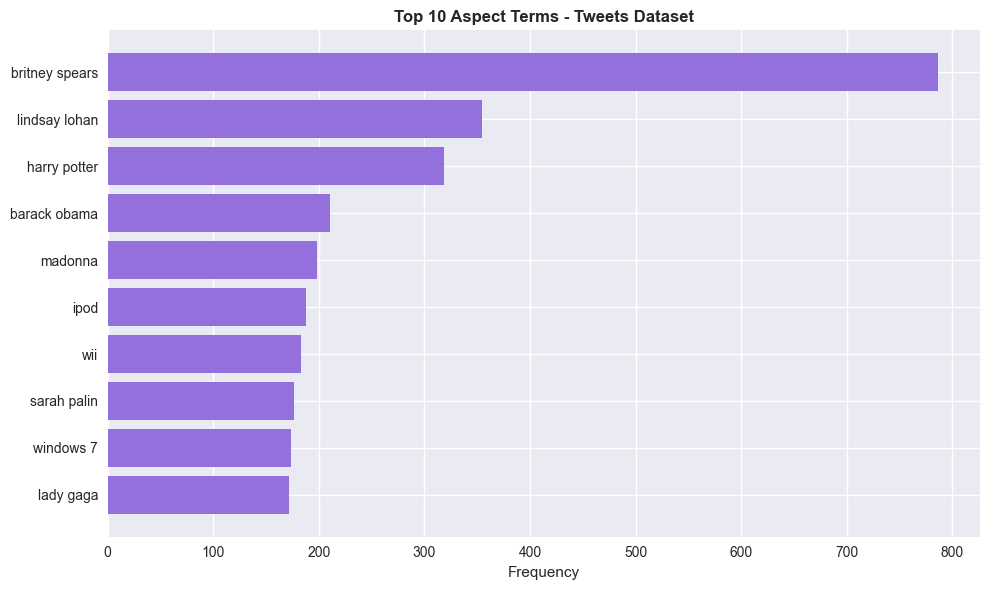

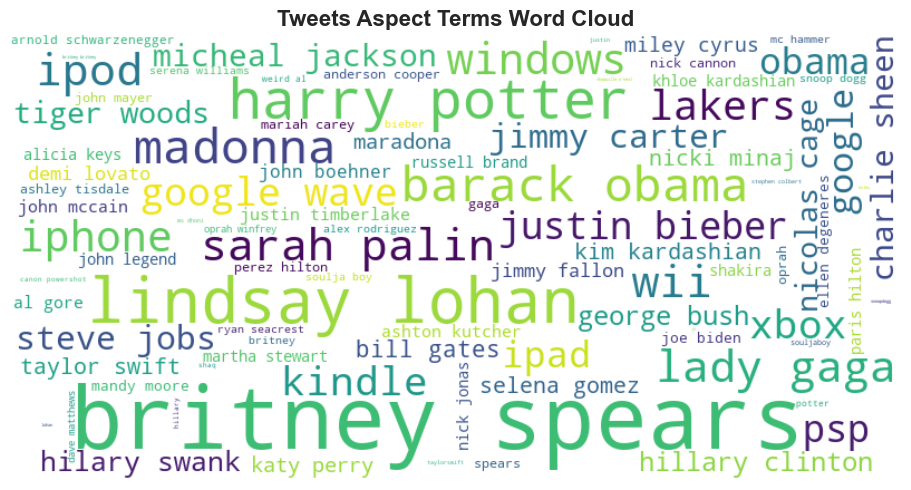

In [92]:
# Tweets Dataset Visualizations
plot_absa_overview(
    tweets_all, 
    dataset_name='Tweets', 
    sentiment_colors=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'],
    aspect_color='mediumpurple',
    word_color='lightgreen'
)
plot_top_aspects(tweets_all, dataset_name='Tweets', color='mediumpurple')
plot_aspect_wordcloud(tweets_all, dataset_name='Tweets', colormap='viridis')